# Fine tuning a VLM (Qwen2-VL-7B) using the Hugging Face ecosystem (trl)

References:

* https://huggingface.co/collections/allenai/molmo-66f379e6fe3b8ef090a8ca19

* https://www.philschmid.de/fine-tune-multimodal-llms-with-trl

* https://github.com/philschmid/deep-learning-pytorch-huggingface/blob/main/training/fine-tune-multimodal-llms-with-trl.ipynb


* https://github.com/huggingface/huggingface-llama-recipes/blob/main/fine_tune/sft_vlm.py


* https://github.com/huggingface/huggingface-llama-recipes/blob/main/fine_tune/peft_finetuning.py

* https://huggingface.co/blog/idefics2

* https://github.com/huggingface/huggingface-llama-recipes/tree/main

* https://huggingface.co/blog/vlms

Outline:

* Understand fine-tuning vs. prompting.
* Select a dataset and setup environment
* Check how the base model performs directly
* Fine-tune model using trl
* Test the model
* Test the model using just prompting.

TODO:

* Generate methods to simplify code
* Generate an Space with the fine-tuned model.
* Add images and explanations


# 1. Install dependencies

Let’s kick off by installing the essential libraries for our project! 🚀

In [1]:
!pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes  peft qwen-vl-utils wandb accelerate
# transformers==4.47.0.dev0, trl==0.12.0.dev0, datasets==3.0.2, bitsandbytes==0.44.1, peft==0.13.2,qwen-vl-utils==0.0.8, wandb==0.18.5, accelerate==1.0.1

#!pip install  -U -q tran formers==4.45.2 trl datasets bitsandbytes peft qwen-vl-utils wandb accelerate
# transformers==4.47.0.dev0, trl==0.12.0.dev0, datasets==3.0.2, bitsandbytes==0.44.1, peft==0.13.2,qwen-vl-utils==0.0.8, wandb==0.18.5, accelerate==1.0.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 61.2 MB/s eta 0:00:00
   ━━━━

In [2]:
# https://github.com/pytorch/pytorch/issues/138340
!pip install torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.0.1
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.21.0.33.21
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread       

Login to upload fine-tuned model!

In [4]:
from huggingface_hub import notebook_login

notebook_login()

# 2. Load dataset

In this section, we will load `HuggingFaceM4/ChartQA` dataset. This dataset containes samples of chart images along with questions and answers for them.



We generate a system message for the LLM. In this case, we would like to generate a system that is an expert in analyzing images and answering questions based on them.

In [5]:
system_message = """You are an expert in analyzing images and answering questions based on the content.
Your answers must always be very short, consisting of either a single word or a single number.
Be concise and precise, providing only the most relevant information in response to the user's question.
"""

We format the dataset in the chatbot structure to use it

In [6]:
# Usage tips! https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct#more-usage-tips
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['query'],
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["label"][0]
                }
            ],
        },
    ]

We only load a 10% out of each split in the dataset for educational purposes, but in a real world use case, we may load the whole set of samples

In [7]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'val[:10%]', 'test[:10%]'])
#train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:1%]', 'val[:1%]', 'test[:1%]'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/852 [00:00<?, ?B/s]

(…)-00000-of-00003-49492f364babfa44.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

(…)-00001-of-00003-7302bae5e425bbc7.parquet:   0%|          | 0.00/311M [00:00<?, ?B/s]

(…)-00002-of-00003-194c9400785577a2.parquet:   0%|          | 0.00/315M [00:00<?, ?B/s]

(…)-00000-of-00001-0f11003c77497969.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

(…)-00000-of-00001-e2cd0b7a0f9eb20d.parquet:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28299 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1920 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [8]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

In [9]:
eval_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 192
})

Let's format the data using the chatbot format

In [10]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [11]:
print(len(eval_dataset))

192


In [12]:
print(train_dataset[200])

[{'role': 'system', 'content': [{'type': 'text', 'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369 at 0x7C5C6330BBE0>}, {'type': 'text', 'text': 'Is the rightmost value of light brown graph 58?'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}]


# 3. Load model and check how it performs!

Now that we've loaded the dataset, let's load the model and see how it performs using a sample from the dataset. In this case, we will be using `Qwen/Qwen2-VL-7B-Instruct`, a VLM that can understand visual data along with texts.

In [13]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig

model_id = "Qwen/Qwen2-VL-7B-Instruct"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

We load the model and the tokenizer

In [25]:
# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Let's see the internal structure of our sample

In [26]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

In [27]:
train_dataset[0][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

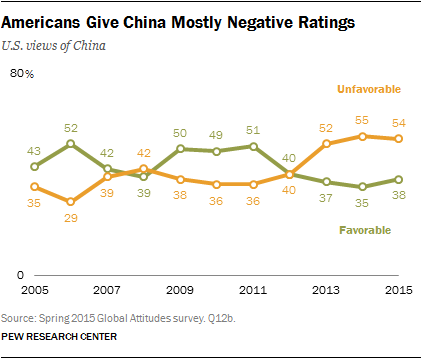

In [28]:
train_dataset[0][1]['content'][0]['image']

In [ ]:
'''
from qwen_vl_utils import process_vision_info

text = processor.apply_chat_template(
    train_dataset[0][1:2],
    tokenize=False,
    add_generation_prompt=True
)

image_inputs, _ = process_vision_info(train_dataset[0])

inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(output_text[0])
'''

'\nfrom qwen_vl_utils import process_vision_info\n\ntext = processor.apply_chat_template(\n    train_dataset[0][1:2],\n    tokenize=False,\n    add_generation_prompt=True\n)\n\nimage_inputs, _ = process_vision_info(train_dataset[0])\n\ninputs = processor(\n    text=[text],\n    images=image_inputs,\n    padding=True,\n    return_tensors="pt",\n)\n\ninputs = inputs.to("cuda")\n\ngenerated_ids = model.generate(**inputs, max_new_tokens=1024)\ngenerated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]\n\noutput_text = processor.batch_decode(\n    generated_ids_trimmed,\n    skip_special_tokens=True,\n    clean_up_tokenization_spaces=False\n)\nprint(output_text[0])\n'

Let's create a method that will receive the model, procesor and sample and based on that will be generating the model answer.

In [29]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Apply chat template to the sample
    text = processor.apply_chat_template(
        sample[1:2],  # Asume que sample está estructurado como el train_dataset
        tokenize=False,
        add_generation_prompt=True
    )

    # Process vision input
    image_inputs, _ = process_vision_info(sample)

    # Prepare inputs for the model
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )

    # Move inputs to the specified device
    inputs = inputs.to(device)

    # Generate text with the model
    generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    # Return the first decoded output text
    return output_text[0]

# Example of how to call the method with sample:
output = generate_text_from_sample(model, processor, train_dataset[0])
print(output)

No, the value of Favorable is not 38 in 2015. According to the chart, the value of Favorable in 2015 is 38.


We can see that the model, although retrieving the correct visual data, it's not able to answer the question correctly.

**Remove model and clean GPU**

We will remove the variables and clean the GPU since we will train the model in the following section.


In [30]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()

# Example of how to call the method:
clear_memory()

In [32]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 6.05 GB
GPU reserved memory: 6.27 GB


# 4. Load the quantized model so we can train it

Now, we will load the quantized model using `BitsAndBytes`.

In [33]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

# 5. Set up QLoRA and SFTConfig

After that, we will set the LoRA configuration for training.

In [34]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation using LoRA
peft_model = get_peft_model(model, peft_config)

# Print details about trainable parameters
peft_model.print_trainable_parameters()

trainable params: 2,523,136 || all params: 8,293,898,752 || trainable%: 0.0304


Let's define the training arguments using `SFTConfig` from `trl`.

In [39]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-trl-sft-ChartQA",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    eval_steps=10,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True,
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=True,
    report_to="wandb",
    gradient_checkpointing_kwargs = {"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs = {"skip_prepare_dataset": True}
)


training_args.remove_unused_columns = False

'''
training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-amazon-description", # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
training_args.remove_unused_columns=False
'''

'\ntraining_args = SFTConfig(\n    output_dir="qwen2-7b-instruct-amazon-description", # directory to save and repository id\n    num_train_epochs=3,                     # number of training epochs\n    per_device_train_batch_size=4,          # batch size per device during training\n    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass\n    gradient_checkpointing=True,            # use gradient checkpointing to save memory\n    optim="adamw_torch_fused",              # use fused adamw optimizer\n    logging_steps=5,                       # log every 10 steps\n    save_strategy="epoch",                  # save checkpoint every epoch\n    learning_rate=2e-4,                     # learning rate, based on QLoRA paper\n    bf16=True,                              # use bfloat16 precision\n    tf32=True,                              # use tf32 precision\n    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper\n    wa

We will be logging the training to `W&B`

In [37]:
import wandb

wandb.init(
    project="qwen2-7b-instruct-trl-sft-ChartQA",  # change this
    name="qwen2-7b-instruct-trl-sft-ChartQA",  # change this
    config=training_args,
)

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/loss,2.5118
eval/runtime,62.2508


We need a collator function to retrieve the data during the training procedure.

In [38]:
# https://github.com/huggingface/trl/blob/a67f2143c38d6520be8735463ce715ad5c281db8/examples/scripts/sft_vlm.py#L87
from qwen_vl_utils import process_vision_info

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example)[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652,151653,151655]
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

Let's define the `SFTTrainer` that will manage the training procedure.

In [40]:
from trl import SFTTrainer

#Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    dataset_text_field="", # needs dummy value
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:310: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:329: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:404: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due 

Time to train the model!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
10,20.738500,1.876583
20,11.072100,0.835459
30,6.056100,0.579719
40,5.134400,0.499931
50,4.219800,0.393471


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Let's save the results

In [ ]:
trainer.save_model(training_args.output_dir)

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

# 6. Test the fine-tuned model!

Now that we have fine-tuned our VLM, let's see how it performs using the previous example.

https://github.com/QwenLM/Qwen2-VL?tab=readme-ov-file#quantize-your-own-model-with-autoawq

Let's begin cleaning the GPU memory

In [ ]:
'''
del model
del processor
del trainer
del peft_model
time.sleep(1)
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()
time.sleep(1)

gc.collect()
'''
clear_memory()

0

In [ ]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.06 GB


In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

We will add the trained adapter to the pretrained model since we only trained this part and not the whole model.

In [ ]:
adapter_path = "sergiopaniego/qwen2-7b-instruct-ChartQA"
model.load_adapter(adapter_path)

adapter_config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

In [ ]:
train_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

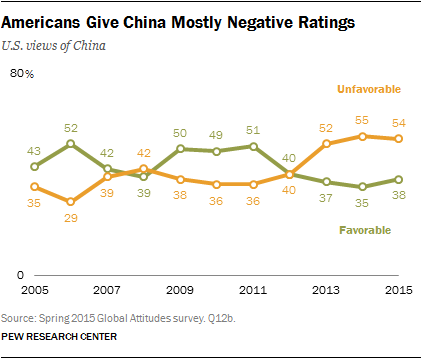

In [ ]:
train_dataset[0][1]['content'][0]['image']

In [ ]:
'''
from qwen_vl_utils import process_vision_info

text = processor.apply_chat_template(
    train_dataset[0][1:2], tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(train_dataset[0])

inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(output_text[0])
'''
output = generate_text_from_sample(model, processor, train_dataset[0])
print(output)

No, the value of Favorable is not 38 in 2015. According to the chart, the value of Favorable in 2015 is 38.


# 7. Compare fine-tuned model vs. base model + prompting

We have seen that fine-tuning the VLM could be an interesting option to be considered for our project in order to adapt it to our needs. Another possible approach would be trying to use directly prompting or implement a RAG system, which is covered in another recipe.

As we have seen, fine-tuning the VLM requires a lot of data and computational power, which comes with some costs. In comparison, we can try directly using prompting to see if we can achieve similar results.

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
train_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

In [ ]:
from qwen_vl_utils import process_vision_info

text = processor.apply_chat_template(
    train_dataset[0][:2], tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(train_dataset[0])

inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(output_text[0])

#output = generate_text_from_sample(model, processor, train_dataset[0])
#print(output)

Yes


# 8. Quantize model and use it